# Inference

In [4]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from src.model import PatentClassifier
import matplotlib.pyplot as plt

In [44]:
# Load the checkpoint
checkpoint_path = '/home/fantoni/patent-sentence-classification/models/best-checkpoint.ckpt'
model_name = "anferico/bert-for-patents"
num_labels = 4

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Tokenizer and Base Model
bert_tokenizer = BertTokenizer.from_pretrained(model_name)
base_model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)

# Load Finetuned Patent Model
loaded_model = PatentClassifier.load_from_checkpoint(checkpoint_path, model=base_model, tokenizer=bert_tokenizer)
loaded_model.eval()
loaded_model.to(device)

Using device: cpu


/home/fantoni/miniconda3/envs/segmentation/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at anferico/bert-for-patents and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


PatentClassifier(
  (model): BertForSequenceClassification(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(39859, 1024, padding_idx=0)
        (position_embeddings): Embedding(512, 1024)
        (token_type_embeddings): Embedding(2, 1024)
        (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-23): 24 x BertLayer(
            (attention): BertAttention(
              (self): BertSdpaSelfAttention(
                (query): Linear(in_features=1024, out_features=1024, bias=True)
                (key): Linear(in_features=1024, out_features=1024, bias=True)
                (value): Linear(in_features=1024, out_features=1024, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=1024, 


Sentence: 'The rigid foam layer 50 is typically selected from the group of polyurethane foams, polyurea foams, and combinations thereof.'
Predicted Class: STR
Probabilities: [0.0, 0.98, 0.01, 0.01]


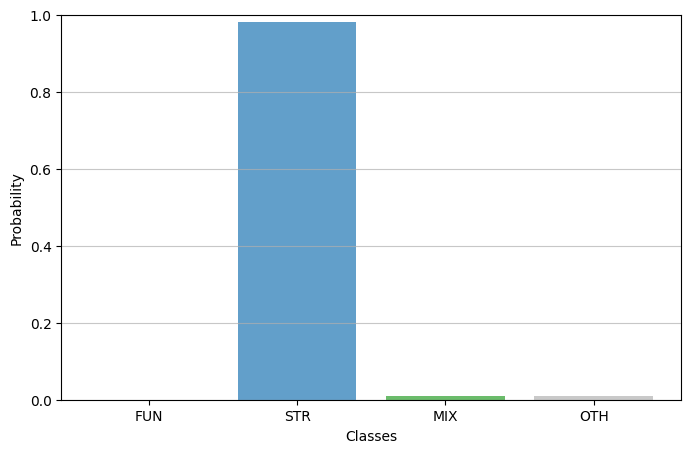

In [51]:
# Select Sentence
text_input = "Additionally, the stopper 108 is used at the distal end of the wire where the loop is formed to substantially secure the loop closed." # MIX
text_input = "Provisional Patent Application number 62/571,193; filed Oct. 11, 2017; and entitled INSECT VACUUM AND TRAP ATTACHMENT SYSTEMS." #OTH
text_input = "In some embodiments, the horizontal position of the idler support block 1213 may be adjustable to maintain tension on the chain 1212." #FUN
text_input = "The rigid foam layer 50 is typically selected from the group of polyurethane foams, polyurea foams, and combinations thereof." # STR

# Tokenize input
tokenizer = loaded_model.tokenizer  # Assuming tokenizer is part of the model
inputs = tokenizer(text_input, truncation=True, padding=True, max_length=512, return_tensors='pt')

# Perform inference
inputs = {k: v.to(device) for k, v in inputs.items()}  # move input to same device
int_to_label = {0: 'FUN', 1: 'STR', 2: 'MIX', 3: 'OTH'}
with torch.no_grad():
    outputs = loaded_model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)

result = {
    'predicted_class': int_to_label[predicted_class.item()],
    'probabilities': [round(prob, 2) for prob in probabilities[0].tolist()]
}

# Visulize Inference
print(f"\nSentence: '{text_input}'\nPredicted Class: {result['predicted_class']}\nProbabilities: {result['probabilities']}")
labels = list(int_to_label.values())
colors = ['#d62728', '#1f77b4', '#2ca02c', '#b2b2b2']  # Red, Blue, Green, Gray

# Plot the bar plot
plt.figure(figsize=(8, 5))
plt.bar(labels, result['probabilities'], color=colors, alpha=0.7)
plt.xlabel("Classes", fontsize=10)
plt.ylabel("Probability", fontsize=10)
plt.ylim(0, 1)  # Probabilities are between 0 and 1
plt.grid(axis='y', alpha=0.7)
plt.show()